# BATTLE OF NEIGHBORHOODS
## ANALYSIS OF HOUSE PRICES & VENUES IN MADRID
### 1. MADRID NEIGHBORHOODS

Madrid is the capital and most populous city of Spain. The city has almost 3.3 million inhabitants and a metropolitan area population of approximately 6.5 million. It is the second-largest city in the European Union (EU), surpassed only by Berlin.

Imagine someone wants to buy a house in Madrid, but not sure about the location. It would be nice if they can compare each neighborhood based of some characteristics. So in this project, we'll analyze each neighborhood in Madrid based on the house prices and venues to be able to recommend a suitable neighborhood for customer needs.

Let's start by importing required libraries.

In [1]:
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import json
import requests
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

c:\users\user\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Now, we need list of the neighborhoods in Madrid. The list can be found on Wikipedia: https://es.wikipedia.org/wiki/Anexo:Barrios_administrativos_de_Madrid

Let's read it from that page and assign to a list variable.

In [2]:
tables = pd.read_html('https://es.wikipedia.org/wiki/Anexo:Barrios_administrativos_de_Madrid')

The first item on the list is the table that we need. So converted it to a dataframe. Let's take a look:

In [3]:
df_madrid = pd.DataFrame(data=tables[0])
df_madrid = df_madrid[['Distrito', 'Nombre']]
df_madrid.columns = ['District', 'Neighborhood']
df_madrid

,District,Neighborhood
0,Centro,Palacio
1,Centro,Embajadores
2,Centro,Cortes
3,Centro,Justicia
4,Centro,Universidad
...,...,...
126,Barajas,Alameda de Osuna
127,Barajas,Aeropuerto
128,Barajas,Casco Histórico de Barajas
129,Barajas,Timón


We have names of all 131 neighborhoods in Madrid. Let's get the coordinates for each neighborhood. I'll read coordinates from csv file.

In [4]:
coordinates = pd.read_csv('madrid_coords.csv')
coordinates

,Neighborhood,Latitude,Longitude
0,Palacio,40.415129,-3.715618
1,Embajadores,40.409681,-3.701644
2,Cortes,40.414779,-3.697584
3,Justicia,40.423957,-3.695747
4,Universidad,40.425409,-3.705989
...,...,...,...
126,Timón,40.476792,-3.594644
127,Corralejos,40.465428,-3.594907
128,Los Cármenes,40.401588,-3.737349
129,Casco Histórico de Barajas,40.474559,-3.579923


In [5]:
# Merge two dataframes and reset index
df_merged = df_madrid.set_index('Neighborhood').join(coordinates.set_index('Neighborhood')).reset_index()
df_merged

,Neighborhood,District,Latitude,Longitude
0,Palacio,Centro,40.415129,-3.715618
1,Embajadores,Centro,40.409681,-3.701644
2,Cortes,Centro,40.414779,-3.697584
3,Justicia,Centro,40.423957,-3.695747
4,Universidad,Centro,40.425409,-3.705989
...,...,...,...,...
126,Alameda de Osuna,Barajas,40.457581,-3.587975
127,Aeropuerto,Barajas,40.494838,-3.574081
128,Casco Histórico de Barajas,Barajas,40.474559,-3.579923
129,Timón,Barajas,40.476792,-3.594644


Now it's time to look for house prices in Madrid. I'm going to use following dataset: https://www.kaggle.com/mirbektoktogaraev/madrid-real-estate-market

Let's read it into a dataframe and take a look:

In [6]:
df_price = pd.read_csv('Madrid.csv')
df_price

,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,latitude,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
0,21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,NaN,...,D,False,NaN,NaN,NaN,NaN,False,True,False,False
1,21741,Piso en venta en calle de la del Manojo de Rosas,"Los Ángeles, Madrid",70.0,NaN,3,1.0,NaN,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21740,"Piso en venta en calle del Talco, 68","Villaverde Alto, Madrid",94.0,54.0,2,2.0,NaN,NaN,NaN,...,no indicado,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21739,Piso en venta en calle Pedro Jiménez,"Villaverde Alto, Madrid",64.0,NaN,2,1.0,NaN,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,False,False,True,False
4,21738,Piso en venta en carretera de Villaverde a Val...,"Los Rosales, Madrid",108.0,90.0,2,2.0,NaN,NaN,NaN,...,en trámite,True,NaN,NaN,True,0.0,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21651,5,Ático en venta en Casco Histórico de Barajas,"Barajas, Madrid",78.0,NaN,2,2.0,NaN,NaN,NaN,...,en trámite,True,NaN,NaN,True,0.0,NaN,NaN,NaN,NaN
21652,4,Piso en venta en Urb. Campo de las Naciones - ...,"Barajas, Madrid",96.0,83.0,2,2.0,NaN,NaN,NaN,...,en trámite,True,NaN,NaN,True,0.0,False,True,True,True
21653,3,Piso en venta en Campo de las Naciones-Corralejos,"Barajas, Madrid",175.0,NaN,4,2.0,NaN,NaN,NaN,...,E,True,NaN,NaN,True,0.0,NaN,NaN,NaN,NaN
21654,2,"Chalet adosado en venta en calle Burriana, 12","Corralejos, Madrid",289.0,NaN,4,3.0,3.0,304.0,NaN,...,en trámite,True,NaN,NaN,True,0.0,False,False,True,False


The dataset contains 21656 houses along with some information like neighborhood, price etc. We'll use only the neighborhood and price per square (m2).

In [7]:
df_price = df_price[['neighborhood_id', 'buy_price_by_area']]
df_price.columns = ['Neighborhood','Price per m2']

Let's calculate average price per m2 for each neighborhood.

In [8]:
df_mean = df_price.groupby('Neighborhood').mean()
df_mean

,Price per m2
Neighborhood,
Abrantes,2069.091837
Acacias,4138.155556
Adelfas,4406.356589
Alameda de Osuna,3241.846154
Almagro,6955.021277
...,...
Ventas,2770.989091
Villaverde Alto,1849.101449
Vinateros,2577.129630


If you've noticed, we have price information of 119 neighborhoods. But our list contains 131 neighborhood. That means we don't have any information about house prices of 12 neighborhoods. So i'll drop these neighborhoods.

In [9]:
# Insert prices into neighborhood dataframe.
df_merged = df_merged.set_index('Neighborhood').join(df_mean)
# Drop neighborhoods with missing prices
df_merged = df_merged.dropna(axis = 0).reset_index()
df_merged

,Neighborhood,District,Latitude,Longitude,Price per m2
0,Palacio,Centro,40.415129,-3.715618,5110.275093
1,Embajadores,Centro,40.409681,-3.701644,4579.672727
2,Cortes,Centro,40.414779,-3.697584,5784.782857
3,Justicia,Centro,40.423957,-3.695747,6393.043988
4,Universidad,Centro,40.425409,-3.705989,5648.284536
...,...,...,...,...,...
114,Rosas,San Blas-Canillejas,40.428713,-3.593758,5395.031690
115,Alameda de Osuna,Barajas,40.457581,-3.587975,3241.846154
116,Casco Histórico de Barajas,Barajas,40.474559,-3.579923,3220.666667
117,Timón,Barajas,40.476792,-3.594644,3074.000000


We have coordinates and price per sq. for 119 neighborhoods. Now let's take a look at venues in each neighborhood. We'll be using Foursquare API to get information about venues.

### 2. VENUES IN MADRID

In [ ]:
# Foursquare API credentials, removed for privacy issues. If you want to run the query, please add your own credentials
CLIENT_ID = '***' # your Foursquare ID
CLIENT_SECRET = '****' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version

I borrowed getNearbyVenues function from previous lab.

In [ ]:
def getNearbyVenues(names, limit, latitudes, longitudes, radius=500,):
    
    venues_list=[]
    for name, lat, lon in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat,
            lon,
            radius, 
            limit)
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            # return only relevant information for each nearby venue
            venues_list.append([(
                name,
                lat,
                lon,
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print('Unable to retrieve venues in ', name)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Latitude',
                  'Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's get the venue data for each neighborhood (max. 100 venue each):

In [ ]:
madrid_venues = getNearbyVenues(names=df_merged['Neighborhood'],
                                latitudes = df_merged['Latitude'],
                                longitudes = df_merged['Longitude'],
                                limit = 100)
madrid_venues.to_csv('madrid_venues.csv')

I'll use the csv file that contains Madrid venues which i got using the function above.

In [10]:
madrid_venues = pd.read_csv('madrid_venues.csv')
madrid_venues

,Neighborhood,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Palacio,40.415129,-3.715618,Santa Iglesia Catedral de Santa María la Real ...,40.415767,-3.714516,Church
1,Palacio,40.415129,-3.715618,Plaza de La Almudena,40.416320,-3.713777,Plaza
2,Palacio,40.415129,-3.715618,Cervecería La Mayor,40.415218,-3.712194,Beer Bar
3,Palacio,40.415129,-3.715618,Taberna Rayuela,40.413179,-3.713496,Tapas Restaurant
4,Palacio,40.415129,-3.715618,Palacio Real de Madrid,40.417940,-3.714259,Palace
...,...,...,...,...,...,...,...
3275,Corralejos,40.465428,-3.594907,Derzu,40.462312,-3.591599,Restaurant
3276,Corralejos,40.465428,-3.594907,No Q No Gastrobar,40.462458,-3.591743,Mexican Restaurant
3277,Corralejos,40.465428,-3.594907,La Fontana,40.463605,-3.592151,Coffee Shop
3278,Corralejos,40.465428,-3.594907,Supercor exprés,40.464940,-3.592667,Supermarket


Foursquare API returned 3280 venues in Madrid. Let's take a look how many venues located in each neighborhood:

In [11]:
venue_counts = madrid_venues.groupby('Neighborhood').count()
venue_counts

,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Abrantes,9,9,9,9,9,9
Acacias,44,44,44,44,44,44
Adelfas,34,34,34,34,34,34
Alameda de Osuna,23,23,23,23,23,23
Almagro,100,100,100,100,100,100
...,...,...,...,...,...,...
Ventas,13,13,13,13,13,13
Villaverde Alto,5,5,5,5,5,5
Vinateros,10,10,10,10,10,10


As you can see, some neighborhoods reached the 100 venue limit and dataframe contains 115 neighborhood. This means Foursquare API didn't return any venue for 4 neighborhoods. I'll drop these neighborhoods as well.

Let's insert these venue numbers to the main dataframe:

In [12]:
df_merged = df_merged.set_index('Neighborhood').join(venue_counts['Venue'])

In [13]:
# Drop neighborhoods with no venue data
df_merged.dropna(axis = 0, inplace = True)
df_merged.rename(columns = {'Venue':'Venues'},inplace = True)
df_merged

,District,Latitude,Longitude,Price per m2,Venues
Neighborhood,,,,,
Palacio,Centro,40.415129,-3.715618,5110.275093,48.0
Embajadores,Centro,40.409681,-3.701644,4579.672727,90.0
Cortes,Centro,40.414779,-3.697584,5784.782857,100.0
Justicia,Centro,40.423957,-3.695747,6393.043988,100.0
Universidad,Centro,40.425409,-3.705989,5648.284536,100.0
...,...,...,...,...,...
Valdebernardo,Vicálvaro,40.399912,-3.621522,2976.365385,7.0
Rosas,San Blas-Canillejas,40.428713,-3.593758,5395.031690,2.0
Alameda de Osuna,Barajas,40.457581,-3.587975,3241.846154,23.0


Main dataframe is completed. It contains 115 neighborhoods along with number of venues and price per m2.

### 3. ANALYZING NEIGHBORHOODS

Now let's classify the neighborhoods. For this purpose, i will use k-Means clustering which is one of the most commonly used clustering methods. We need to specify number of cluster, so i'll use KElbowVisualizer from Yellowbrick package to determine the number of clusters.

In [14]:
# Take only numeric values for clustering
df_cluster = df_merged[['Price per m2','Venues']]

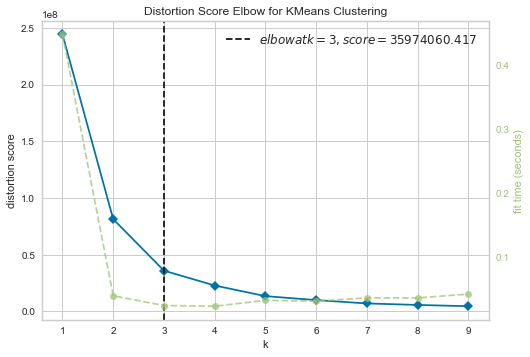

In [15]:
# Create a KMeans instance
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,10)) # Try 1 to 10 cluster to decide best cluster (k) value
visualizer.fit(df_cluster)        # Fit the data to the visualizer
visualizer.show()                 # Finalize and render the figure

The figure above illustrates that the best 'k' value for clustering is 3. So let's create an KMeans object with k = 3

In [16]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_cluster)

We clustered the neighborhoods into 3 different clusters by number of venues and price per sq. Now let's insert cluster labels to the main dataframe.

In [17]:
#Insert cluster labels into the main dataframe
df_merged.insert(0, 'Cluster Labels', kmeans.labels_)
#Cast cluster labels to int
df_merged['Venues'] = df_merged['Venues'].astype(int)
# Reset index
df_merged = df_merged.reset_index()
df_merged

,Neighborhood,Cluster Labels,District,Latitude,Longitude,Price per m2,Venues
0,Palacio,1,Centro,40.415129,-3.715618,5110.275093,48
1,Embajadores,1,Centro,40.409681,-3.701644,4579.672727,90
2,Cortes,2,Centro,40.414779,-3.697584,5784.782857,100
3,Justicia,2,Centro,40.423957,-3.695747,6393.043988,100
4,Universidad,2,Centro,40.425409,-3.705989,5648.284536,100
...,...,...,...,...,...,...,...
110,Valdebernardo,0,Vicálvaro,40.399912,-3.621522,2976.365385,7
111,Rosas,2,San Blas-Canillejas,40.428713,-3.593758,5395.031690,2
112,Alameda de Osuna,0,Barajas,40.457581,-3.587975,3241.846154,23
113,Casco Histórico de Barajas,0,Barajas,40.474559,-3.579923,3220.666667,37


So far, we calculated average house price and get the number of venues for each neighborhood. Then, we clustered these neighborhood into 3 different cluster using k-Means clustering algorithm. Now let's examine these clusters:

In [18]:
# Ignore location data
df_clusters = df_merged[['Neighborhood','Cluster Labels','Price per m2','Venues']]
# Grouping dataframe by cluster labels and calculating average values
df_clusters = df_clusters.groupby('Cluster Labels').mean()
df_clusters

,Price per m2,Venues
Cluster Labels,,
0,2442.749309,12.313725
1,4159.265470,32.531915
2,6331.493822,66.058824


Let's create two bar plot for two columns ('Price per m2' and 'Venues') and examine the results:

Text(0.5, 0, 'Cluster Labels')

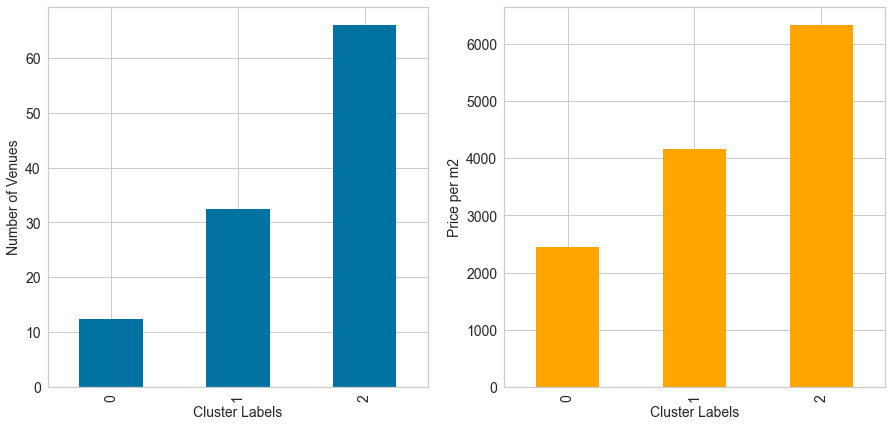

In [21]:
plt.subplot(1,2,1)
# Plot average number of venues for each cluster
df_clusters['Venues'].plot(kind='bar',figsize = (15,7), fontsize = 14)
# Edit labels
plt.ylabel('Number of Venues', size = 14)
plt.xlabel('Cluster Labels', size = 14)

plt.subplot(1,2,2)
#Plot average house prices for each cluster
df_clusters['Price per m2'].plot(kind='bar',figsize = (15,7), color = 'orange', fontsize = 14)
# Edit labels
plt.ylabel('Price per m2',size = 14)
plt.xlabel('Cluster Labels', size = 14)

As you can see, neighborhoods in Cluster 0 has lowest house prices and around 10 venues while neighborhoods in Cluster 2 has the highest prices along with 65 venues average. Also based on these plots it's possible to say that expensive neighborhoods also has more venues vice-versa. Buying house from Cluster 1 would be considered because those neighborhoods has enough venues and the prices are not high as Cluster 2.

Now let's analyze the districts:

In [22]:
df_dist = df_merged[['District','Price per m2','Venues']].groupby('District').mean()
df_dist = df_dist.sort_values(by = 'Price per m2')
df_dist

,Price per m2,Venues
District,,
Villaverde,1892.659546,5.000000
Puente de Vallecas,2004.031456,7.000000
Usera,2131.758367,12.857143
Carabanchel,2300.727784,12.571429
Villa de Vallecas,2480.679912,24.000000
Latina,2541.413087,10.571429
Moratalaz,2635.664389,8.500000
Vicálvaro,2976.365385,7.000000
Barajas,3328.319088,22.333333


We calculated average house prices and number of venues for each district. Let's plot house prices for corresponding district to compare easily. I'll create a horizontal bar plot.

Text(0.5, 1.0, 'House Prices in Districts of Madrid (EUR/m2)')

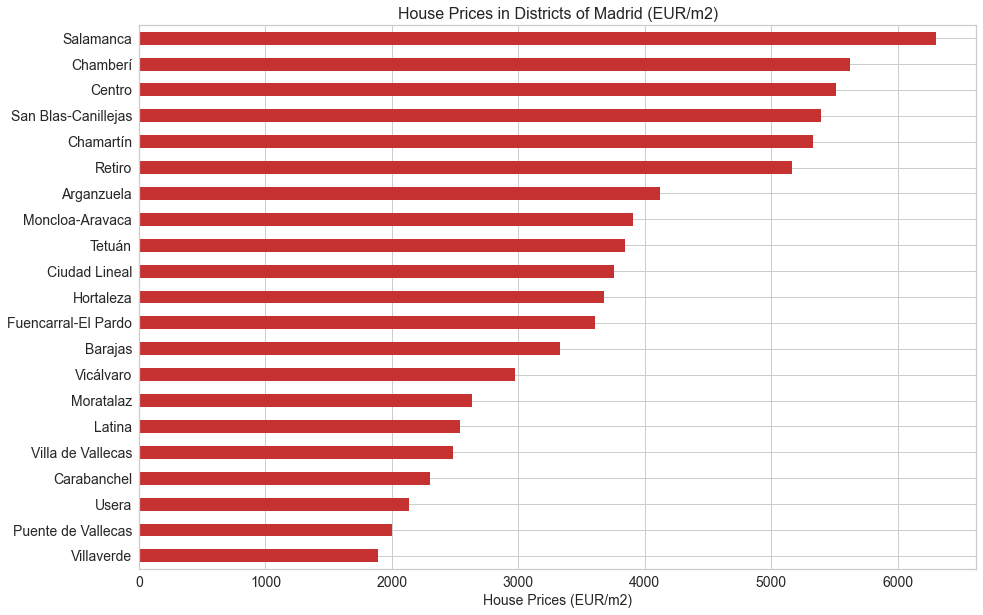

In [23]:
# Create a horizontal bar plot
df_dist['Price per m2'].plot(kind = 'barh', color = '#c63232', figsize = (15,10), fontsize=14)
plt.xlabel('House Prices (EUR/m2)', size = 14)
plt.ylabel('')
plt.title('House Prices in Districts of Madrid (EUR/m2)',size=16)

The figure above shows that **Salamanca** district has the highest house pricing while **Villaverde** district has the lowest.

Now let's analyze house prices for each district by visualizing on the map.

In [24]:
# Resetting index column
df_dist = df_dist.reset_index()

I encountered some problems while trying to create a choropleth map with folium. After some struggling, i noticed that map was not created correctly due to the special characters like é,í etc. in district names. So i'm replacing those names as you can see below. I also updated the geojson file to be able to generate a correct map.

In [25]:
df_dist.replace({'Chamartín':'Chamartin', 'Chamberí':'Chamberi', 'Tetuán' :'Tetuan',
                 'Vicálvaro':'Vicalvaro'}, inplace = True)

In [26]:
#District boundaries
with open('madrid_districts.json') as jfile:
    madrid_geo_dist = json.load(jfile)
#Neighborhood boundaries
with open('madrid_neighborhoods.json') as jfile:
    madrid_geo_nei = json.load(jfile)

Let's create a choropleth map of Madrid based on house prices.

In [27]:
# Create a map zoomed in Madrid
map_madrid = folium.Map(location=[40.4230317,-3.7171571], zoom_start=11)

# set color scheme for the clusters
markers_colors = ['blue','purple','red']

#Choropleth of neighborhoods
folium.Choropleth(
    geo_data=madrid_geo_nei,
    name='choropleth',
    key_on='feature.properties.nombre',
    fill_color='YlGn',
    fill_opacity=0.3,
    line_opacity=0.5,
).add_to(map_madrid)

#Choropleth of districts
ch_dist = folium.Choropleth(
    geo_data=madrid_geo_dist,
    name='choropleth',
    data=df_dist,
    columns=['District', 'Price per m2'],
    key_on='feature.properties.nombre',
    fill_color='YlGn',
    fill_opacity=0.8,
    line_opacity=0.8,
    legend_name='Price per m2'
).add_to(map_madrid)

# Add names of the districts to district choropleth
style_function = "font-size: 14px"
ch_dist.geojson.add_child(
    folium.features.GeoJsonTooltip(['nombre'], style=style_function, labels=False))

#Add markers to neighborhoods
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    #label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        location = [lat, lon],
        radius=5,
        popup='{}, Cluster: {}'.format(str(poi),int(cluster)),
        color=markers_colors[cluster],
        fill=True,
        fill_color=markers_colors[cluster],
        fill_opacity=0.7,
        line_opacity=0.7
    ).add_to(map_madrid)
       

In [28]:
map_madrid

The map illustrates comparison of districts based on the house prices. Darker areas have higher house prices. Also you can see that each neighborhood appointed with a marker based on it's cluster. So neighborhoods with same markers belongs to same cluster.

### 4. CONCLUSION

So, the map above provides a insight about house prices and venues for each neighborhood. Customers can find suitable neighborhoods for their needs. For example, if someone is looking for a house around 4000 EUR/m2, neighborhoods in Cluster 1 (purple marker) is might be considered. If customer can afford more expensive houses, Cluster 2 (red markers) is a good choice.
********